In [1]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import util
from util import inv_phi_range
from util import FWHM
import model as m

from tensorflow import keras
from tensorflow.keras import layers
from keras.engine import data_adapter

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from qkeras import QBatchNormalization
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

import hls4ml

/home/diptarko/.local/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [2]:
phi_div  = 64
eta_div  = 64
pt_div   = 64
qual_div = 64

teacher_hidden_neurons = 256
corrector_hidden_neurons = 4
k_reg          = kernel_regularizer=regularizers.l2(1e-4)
a_reg          = kernel_regularizer=regularizers.l2(1e-4)
ap_fixed       = [18, 5]
target_sparsity = 0

n_epochs     = 100
batch_size   = 1024

lr = 1e-4
device = 0

train   = True
pruning = False

distillation_loss_fn = keras.losses.MeanSquaredError() 
distill_alpha = 0.1
lr_distill = 0.01

# ckpt_file      = "checkpoints/run3_uGMT_nn_recal_checkpoint.h5"

In [4]:
DATAPATH  = "/home/rardino/data/run3/"
MODELPATH = "./models/run3/"

if not os.path.exists(MODELPATH): os.makedirs(MODELPATH)

/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")


train_len =  619108
Train df shape: (619108, 34)
Test  df shape: (32585, 34)
X train shape: (619108, 5)
Y train shape: (619108, 3)
X test  shape: (32585, 5)
Y test  shape: (32585, 3)


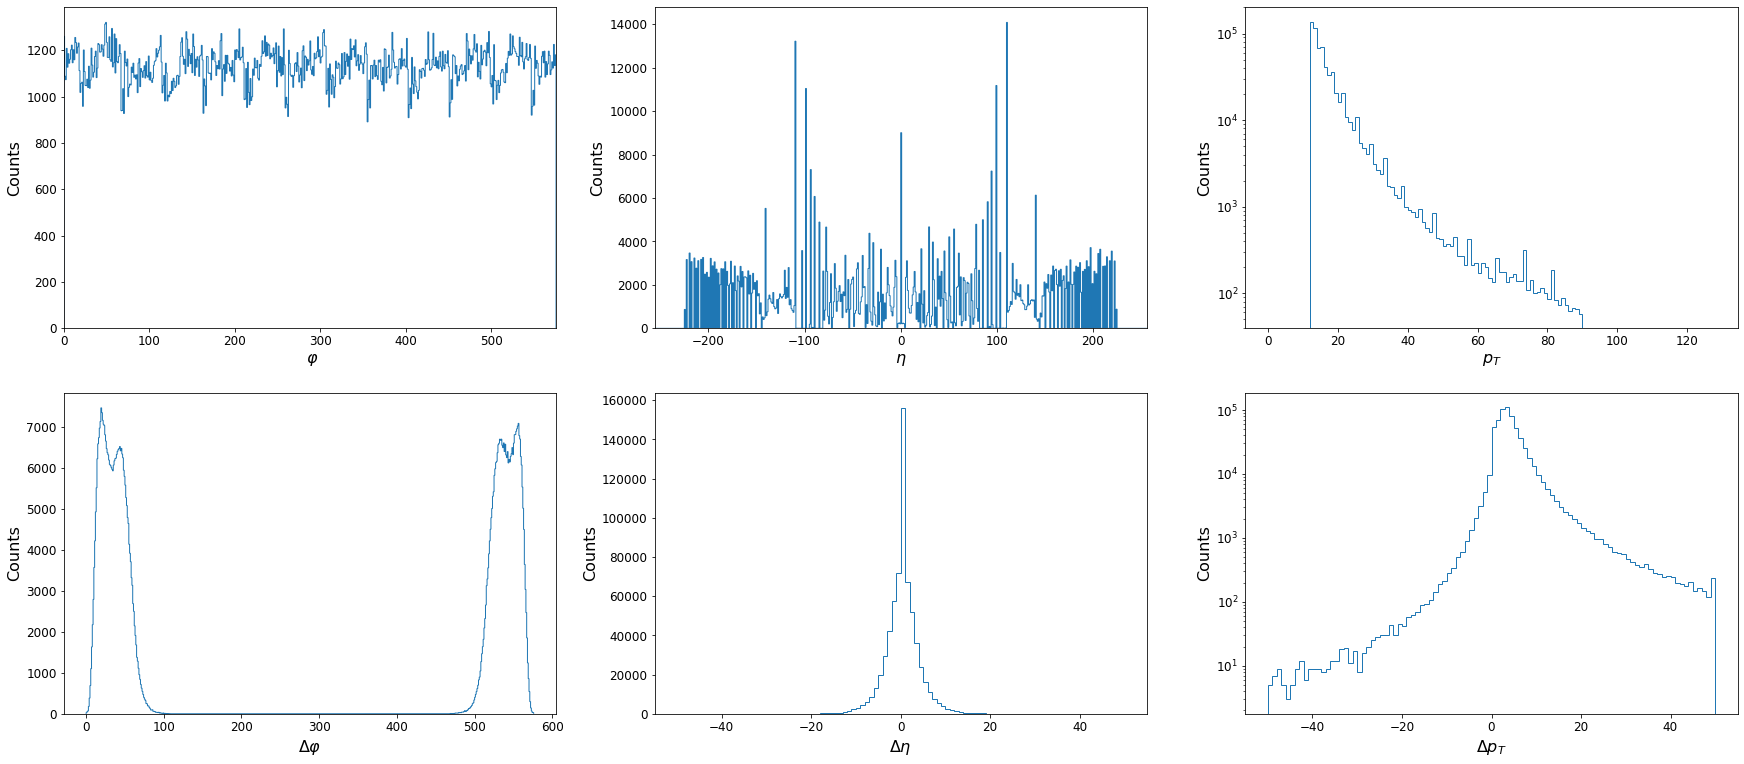

In [5]:
df_base =util.load_data([
    os.path.join(DATAPATH,"run3golden_mm_singles.csv")
                 ])
df_base = util.apply_cut(df_base, 5.5, 45)
train_data, test_data, df_train, df_test = util.preprocess_data(df_base)
x_train, y_train = train_data
x_test, y_test = test_data
util.plot_data(df_base)

In [6]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,):
        
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        teacher_predictions = teacher_predictions[:,2]

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (self.distillation_loss_fn(teacher_predictions,student_predictions))

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
    
    
    def predict_step(self, data):
        x, _, _ = data_adapter.unpack_x_y_sample_weight(data)
        return self.student(x, training=False)

In [7]:
teacher = m.make_model(hidden_neurons=teacher_hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)

corrector = m.make_model(hidden_neurons=corrector_hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed,
                     corrector = True
                        )
if pruning:
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(target_sparsity, begin_step=2000, frequency=100)}
    corrector = prune.prune_low_magnitude(corrector, **pruning_params)

opt          = Adam(learning_rate=lr)
losses       = ['logcosh', 'logcosh','logcosh']
loss_weights = [1, 1, 1]

2023-07-26 18:47:17.489462: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 18:47:18.837638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9118 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-07-26 18:47:18.838745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9606 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


In [8]:
if train:
    early_stopping = EarlyStopping(
        monitor  = 'val_loss',
        patience = 20
    )
    reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               factor=0.5,
                                                               patience=5,
                                                               verbose=1,
                                                               mode="auto",
                                                               min_delta=0.001,
                                                               cooldown=0,
                                                               min_lr=0)

    checkpoint = ModelCheckpoint(
        "./checkpoints/teacher.h5",
        monitor           = 'val_loss',
        verbose           = 1,
        save_best_only    = True,
        save_weights_only = False
    )

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
    callbacks = [early_stopping,
#                  checkpoint,
                 reduce_lr_on_plateu, 
                                     FWHM(x_test,
                                      y_test,
                                      df_test,
                                      use_wandb=False,
                                      verbose=True)]


#     callbacks.append(pruning_callbacks.UpdatePruningStep())

    with tf.device(f'/device:GPU:{device}'):    
            teacher.compile(
                loss         = losses,
                loss_weights = loss_weights,
                optimizer    = opt,
            #         metrics=[fwhm]
            )

            teacher.fit(
                x_train, y_train,
                callbacks=callbacks,
                batch_size=batch_size,
                epochs=1,
                validation_split=0.1,
                shuffle=True,
                verbose = 1
                #callbacks = callbacks.callbacks
            )

2023-07-26 18:47:22.928830: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


545/545 [==============================] - 7s 7ms/step - loss: 0.1126 - val_loss: 0.1046
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3810000000000011
FWHM phi uGMT-EXT 0.2340000000000002
-------------------------------------
FWHM eta uGMT 0.07999999999999996
FWHM eta uGMT-EXT 0.06399999999999995
FWHM pt uGMT 0.49200000000000044
-------------------------------------
FWHM phi NN 0.17200000000000015
FWHM eta NN 0.09200000000000019
FWHM pt-NN 0.6820000000000006
-------------------------------------
-------------------------------------


In [9]:
#The checkpoint loading code not needed wshen the notbook is runned
teacher.load_weights("./checkpoints/teacher.h5")

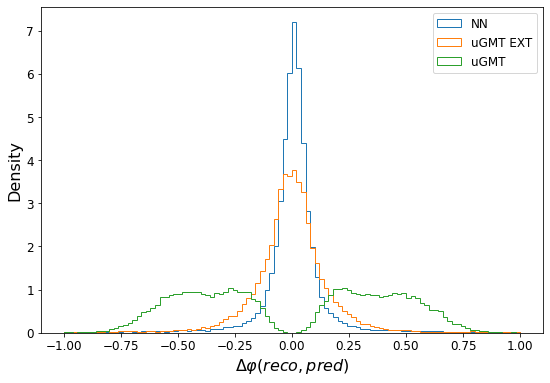

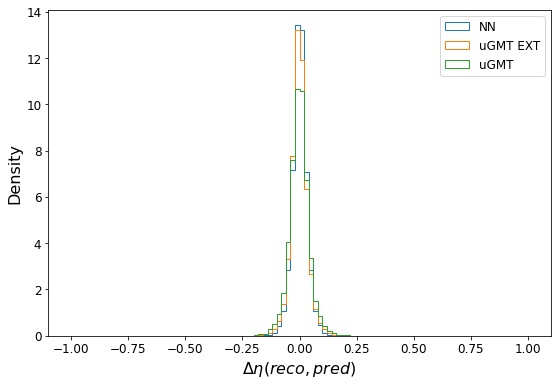

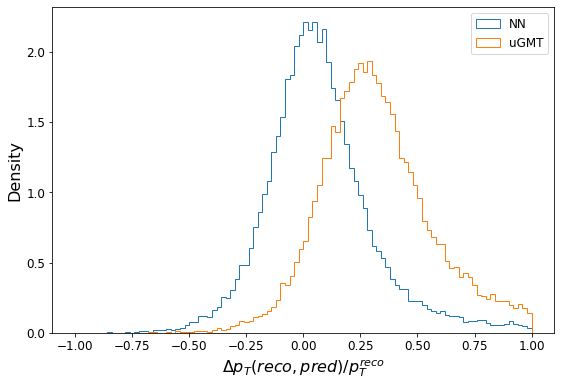

FWHM of delta_phi for the Neural Network Qkeras 0.121
FWHM of delta_eta for the Neural Network Qkeras 0.061000000000000054
FWHM of delta_pt for the Neural Network Qkeras 0.4160000000000005


In [10]:
util.evaluate_keras(model = teacher,
                   x_test = x_test,
                   y_test = y_test,
                   df_train = df_train,
                   df_test = df_test,
                   phi_div = phi_div,
                   eta_div = eta_div,
                   pt_div = pt_div,
                   qual_div = qual_div,
                   batch_size = 2048)

In [11]:
# Initialize and compile distiller
distiller = Distiller(student=corrector, teacher=teacher)

early_stopping = EarlyStopping(
    monitor  = 'val_student_loss',
    patience = 50
)
reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_student_loss",
                                                           factor=0.5,
                                                           patience=10,
                                                           verbose=1,
                                                           mode="auto",
                                                           min_delta=0.001,
                                                           cooldown=0,
                                                           min_lr=0)

checkpoint = ModelCheckpoint(
    MODELPATH + "/qmodel_hl_4__hn_128__qrelu__reg_0p0001l2__ep_20__bs_1024_checkpoint.h5",
    monitor           = 'val_student_loss',
    verbose           = 1,
    save_best_only    = True,
    save_weights_only = False
)


callbacks = [early_stopping,
             reduce_lr_on_plateu
            ]

callbacks.append(pruning_callbacks.UpdatePruningStep())

with tf.device(f'/device:GPU:{device}'):    
    distiller.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_distill),
        metrics=[],
        student_loss_fn=keras.losses.LogCosh(),
        distillation_loss_fn=distillation_loss_fn,
        alpha=distill_alpha
    )
#     Distill teacher to student
    distiller.fit(x_train, y_train[:,2],
                  callbacks=callbacks,
                  verbose = 1,
                  batch_size=batch_size,
                  validation_split=0.1,
                  epochs=50)

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/50
545/545 [==============================] - 8s 8ms/step - student_loss: 0.0029 - distillation_loss: 0.0021 - val_student_loss: 0.0022
Epoch 2/50
545/545 [==============================] - 4s 7ms/step - student_loss: 0.0021 - distillation_loss: 3.6666e-04 - val_student_loss: 0.0016
Epoch 3/50
545/545 [==============================] - 4s 7ms/step - student_loss: 0.0021 - distillation_loss: 3.2968e-04 - val_student_loss: 0.0015
Epoch 4/50
545/545 [==============================] - 4s 7ms/step - student_loss: 0.0021 - distillation_loss: 3.0841e-04 - val_student_loss: 0.0014
Epoch 5/50
545/545 [==============================] - 4s 7ms/step - student_loss: 0.0021 - distillation_loss: 2.8039e-04 - val_student_loss: 0.0016
Epoch 6/50
545/545 [==============================] - 4s 7ms/step - student_loss: 0.0021 - distillation_loss: 2.6364e-04 - val_student_loss: 0.0014
Epoch 7/50
545/545 [==============================] - 4s 7ms/step - student_loss: 0.0021 - distillation_loss: 2.6431

0.06407666206359863

In [12]:
y_test.shape

(32585, 3)

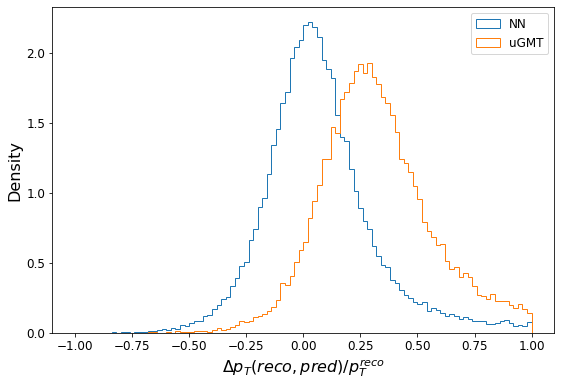

FWHM of delta_pt for the Neural Network Qkeras 0.41600000000000026


In [13]:
util.evaluate_corrector(model = corrector,
                   x_test = x_test,
                   y_test = y_test,
                   df_train = df_train,
                   df_test = df_test,
                   phi_div = phi_div,
                   eta_div = eta_div,
                   pt_div = pt_div,
                   qual_div = qual_div,
                   batch_size = 2048)

In [14]:
corrector.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hd1 (QDense)                 (None, 4)                 24        
_________________________________________________________________
bn1 (QBatchNormalization)    (None, 4)                 16        
_________________________________________________________________
act1 (QActivation)           (None, 4)                 0         
_________________________________________________________________
hd2 (QDense)                 (None, 4)                 20        
_________________________________________________________________
bn2 (QBatchNormalization)    (None, 4)                 16        
_________________________________________________________________
act2 (QActivation)           (None, 4)                 0         
_________________________________________________________________
hd3 (QDense)                 (None, 4)                

In [15]:
corrector.save('corrector-recalibration/best')

2023-07-26 18:51:38.528777: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: corrector-recalibration/best/assets


In [17]:
config = hls4ml.utils.config_from_keras_model(corrector, granularity='model')
config["Model"]["Precision"] = "ap_fixed<18,6>"
config['Model']['ReuseFactor'] = 4
c_config = hls4ml.converters.create_config(project_name ='nn_ugmt_recal_run3',
                                           output_dir="tmp/hls4ml_test",
                                           clock_period=4,
                                           part='xcvu37p-fsvh2892-2L-e',
                                           backend='Vivado')
c_config['HLSConfig'] = config
c_config['KerasModel'] = corrector
hls_model = hls4ml.converters.convert_from_config(c_config)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: hd1_input, layer type: InputLayer, input shapes: [[None, 5]], output shape: [None, 5]
Layer name: hd1, layer type: QDense, input shapes: [[None, 5]], output shape: [None, 4]
Layer name: bn1, layer type: QBatchNormalization, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: act1, layer type: Activation, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: hd2, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: bn2, layer type: QBatchNormalization, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: act2, layer type: Activation, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: hd3, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: bn3, layer type: QBatchNormalization, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: act3, layer type: Activation, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: hd4, layer

In [18]:
os.environ["OMP_NUM_THREADS"] = "10"
os.environ['PATH'] = '/home/xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
os.environ['LD_LIBRARY_PATH'] = '/usr/lib64'

hls_logs = hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'diptarko' on host 'pcgpu-c2f07-18-01.cern.ch' (Linux_x86_64 version 4.18.0-497.el8.x86_64) on Wed Jul 26 18:53:37 CEST 2023
INFO: [HLS 200-10] On os "CentOS Stream release 8"
INFO: [HLS 200-10] In directory '/home/diptarko/Refactory/tmp/hls4ml_test'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/diptarko/Refactory/tmp/hls4ml_test/nn_ugmt_recal_run3_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/nn_ugmt_recal_run3.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'nn_ugmt_recal_run3_test.cpp' to t

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18>' (firmware/nnet_utils/nnet_dense_latency.h:13:43).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, relu_config17>' (firmware/nnet_utils/nnet_activation.h:40:43).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config16>' (firmware/nnet_utils/nnet_batchnorm.h:37:47).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config14>' (firmware/nnet_utils/nnet_dense_latency.h:17:48).
INFO: [XFORM 203-502] Unrol

INFO: [HLS 200-489] Unrolling loop 'Product1' (firmware/nnet_utils/nnet_dense_latency.h:37) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 5.
INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:40) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:48) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:54) in function 'nnet::dense_latency<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:79) by setting 'bias[0].V' to 'b12.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config12>.0.0.0.0.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:79) by setting 'bias[1].V' to 'b12.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:55) by setting 'scale[2].V' to 's4.V.2'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0'(firmware/nnet_utils/nnet_batchnorm.h:42:1) to 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0' at call site (firmware/nn_ugmt_recal_run3.cpp:55) by setting 'scale[3].V' to 's4.V.3'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<18, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<18, 6, (a

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:00:23 ; elapsed = 00:00:26 . Memory (MB): peak = 1080.336 ; gain = 658.125 ; free physical = 126392 ; free virtual = 241543
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'nn_ugmt_recal_run3' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_fixed_ap_fixed_18_6_5_3_0_config2_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed<18,6,5,3,0>,config2>.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 4, Final II = 4, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 26.66 seconds; current allocated memory: 265.806 MB.
INFO: [BIND 205-100] Starting micro-architecture generation 

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.1 seconds; current allocated memory: 267.824 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_fixed_ap_fixed_18_6_5_3_0_config10_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed,ap_fixed<18,6,5,3,0>,config10>.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 4, Final II = 4, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.15 seconds; current allocated memory: 268.099 MB.
INFO: [BI

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.72 seconds; current allocated memory: 271.282 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_fixed_ap_fixed_18_6_5_3_0_config2_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_ap_fixed_ap_fixed_18_6_5_3_0_config2_0_0_0_0_0'.
INFO: [HLS 200-111]  Elapsed time: 0.35 seconds; current allocated memory: 272.035 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize_ap_fixed_ap_fixed_18_6_5_3_0_config4_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'normalize_ap_fixed_ap_fixed_18

In [19]:
hls_logs

{'CSynthesisReport': {'TargetClockPeriod': '4.00',
  'EstimatedClockPeriod': '3.397',
  'BestLatency': '39',
  'WorstLatency': '39',
  'IntervalMin': '4',
  'IntervalMax': '4',
  'DSP': '22',
  'FF': '2662',
  'LUT': '3971',
  'BRAM_18K': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '4032',
  'AvailableDSP': '9024',
  'AvailableFF': '2607360',
  'AvailableLUT': '1303680',
  'AvailableURAM': '960'}}